In [ ]:
from google.colab import files
files.upload()

Saving glove.6B.50d.txt to glove.6B.50d.txt


In [ ]:
import keras
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize
import numpy as np
import pickle
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
import warnings
import logging
import pandas as pd
from contextlib import redirect_stdout
logging.basicConfig(level=logging.INFO)

#import dataframe and drop unnecessary columns

# mydata=pd.read_csv('FINAL_MONTH_.csv')
mydata=pd.read_csv('dataset.csv',skiprows=[0,1,2])
mydataframe=pd.DataFrame(mydata)
del mydataframe['Unnamed: 0']
del mydataframe['Unnamed: 0.1']
del mydataframe['Unnamed: 0.1.1']
#print(mydataframe.head()) 


#label encoder on the target variable
encoder=LabelEncoder()
mydataframe['label']=encoder.fit_transform(mydataframe['label'])

# the preprocessing function to prepare our text for training and testing
def model_preprocessing(train_data,test_data,MAX_WORDS=80000, MAX_SEQ_LEN=1000):
    np.random.seed(7)
    txt=np.concatenate((train_data,test_data),axis=0)
    txt=np.array(txt)
    tok=Tokenizer(num_words=MAX_WORDS)
    tok.fit_on_texts(txt)
    pickle.dump(tok,open('text_tokenizer_adam.pkl','wb'))
    seq=tok.texts_to_sequences(txt)
    word_index=tok.word_index
    txt=pad_sequences(seq,maxlen=MAX_SEQ_LEN)
    ind=np.arange(txt.shape[0])
    #np.random.shuffle(ind)
    txt=txt[ind]
    train_data_Glove=txt[0:len(train_data), ]
    test_data_Glove=txt[len(train_data):, ]
    dictionary_embedding={}
    func=open("glove.6B.50d.txt",encoding="utf8")
    for l in func:
        val=l.split()
        wrd=val[0]
        try:
            coefficients=np.asarray(val[1:], dtype='float32')
        except:
            pass
        dictionary_embedding[wrd]=coefficients
    func.close()
    return(train_data_Glove,test_data_Glove,word_index,dictionary_embedding)

def model_building_blstm(word_index, dictionary_embedding,nclasses, MAX_SEQ_LEN=1000, dropout=0.2, hidden_layer=3, lstm_node=32,EMBEDDING_DIMS=50):
    blstm_model=Sequential() # model is sequntial
    matrix_embedding=np.random.random((len(word_index)+1,EMBEDDING_DIMS)) # make embedding matrix
    for wrd,i in word_index.items():
        vector_embedding=dictionary_embedding.get(wrd)
        if vector_embedding is not None:
            if len(matrix_embedding[i]) != len(vector_embedding):
                print("errorrrrr")
                exit(1)
            matrix_embedding[i]=vector_embedding
    
    #Now add an embedding layer
    blstm_model.add(Embedding(len(word_index)+1,EMBEDDING_DIMS,weights=[matrix_embedding],input_length=MAX_SEQ_LEN,trainable=True))
    
    #Hidden layers - for every layer bi-lstm followed by dropout layer
    for i in range (0,hidden_layer):
        blstm_model.add(Bidirectional(LSTM(lstm_node,recurrent_dropout=0.2,return_sequences=True)))
        blstm_model.add(Dropout(dropout))
    blstm_model.add(Bidirectional(LSTM(lstm_node,recurrent_dropout=0.2,return_sequences=False)))
    blstm_model.add(Dropout(dropout))
    blstm_model.add(Dense(256,activation='relu')) #fully connected layer
    blstm_model.add(Dense(nclasses,activation='softmax'))
    blstm_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return blstm_model

X=mydataframe['text']
Y=mydataframe['label']
train_data, test_data, train_data_y, test_data_y=train_test_split(X,Y,test_size=0.2)
train_data_Glove, test_data_Glove, word_index, dictionary_embedding= model_preprocessing(train_data, test_data) 
blstm_model= model_building_blstm(word_index, dictionary_embedding,3)
#blstm_model=pickle.load(open('blstm_model.pkl','rb'))
blstm_model.summary()
#with open('bi-lstm_summary_adgrad.txt','w') as f:
with open('bi-lstm_summary_adam.txt','w') as f:
    with redirect_stdout(f):
        blstm_model.summary()



    

    
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 50)          2402400   
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 64)          21248     
_________________________________________________________________
dropout (Dropout)            (None, 1000, 64)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 64)          24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 64)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 64)          24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000, 64)          0

Epoch 1/3
105/105 [==============================] - 2338s 22s/step - loss: 0.7749 - accuracy: 0.6662 - val_loss: 0.6754 - val_accuracy: 0.7127
Epoch 2/3
105/105 [==============================] - 2324s 22s/step - loss: 0.5816 - accuracy: 0.7651 - val_loss: 0.5408 - val_accuracy: 0.7829
Epoch 3/3
105/105 [==============================] - 2277s 22s/step - loss: 0.4152 - accuracy: 0.8392 - val_loss: 0.4469 - val_accuracy: 0.8233


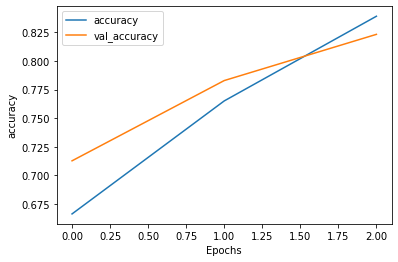

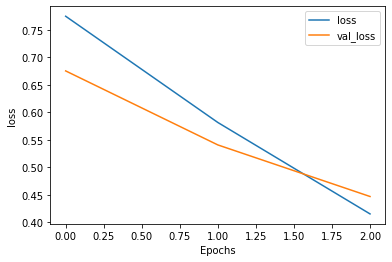

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'0': {'precision': 0.7347043701799486, 'recall': 0.7621333333333333, 'f1-score': 0.7481675392670156, 'support': 1875}, '1': {'precision': 0.8744855967078189, 'recall': 0.9029745042492918, 'f1-score': 0.8885017421602788, 'support': 4236}, '2': {'precision': 0.6805555555555556, 'recall': 0.43133802816901406, 'f1-score': 0.5280172413793104, 'support': 568}, 'accuracy': 0.8233268453361282, 'macro avg': {'precision': 0.7632485074811077, 'recall': 0.6988152885838798, 'f1-score': 0.7215621742688683, 'support': 6679}, 'weighted avg': {'precision': 0.8187523936663094, 'recall': 0.8233268453361282, 'f1-score': 0.8184490655816804, 'support': 6679}}




In [ ]:
# TRAINING AND EVALUATING
def evaluating_report(labels,predictions):
    matt_coeff=matthews_corrcoef(labels,predictions)
   
    confusion_=confusion_matrix(labels,predictions)
    
    fp=confusion_.sum(axis=0)-np.diag(confusion_)
    fn=confusion_.sum(axis=1)-np.diag(confusion_)
    tp=np.diag(confusion_)
    tn=confusion_.sum()-(fp+fn+tp)
    
    
        
    precision=tp/(tp+fn)
    recall=tp/(tp+fn)
    f1=(2*(precision*recall))/(precision+ recall)
    return{
        "matthews_correlation_coefficient" : matt_coeff,
        "true positive": tp,
        "true negative":tn,
        "false positive":fp,
        "false negative":fn,
        "precision": precision,
        "recall": recall,
        "F1": f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
        
        
        }

def computing_metrics(labels,predictions):
    assert len(predictions)==len(labels)
    return evaluating_report(labels,predictions)

def graph_plotting(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' +string],'')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
   
    plt.show()
    
history=blstm_model.fit(train_data_Glove,train_data_y,validation_data=(test_data_Glove,test_data_y),epochs=3,batch_size=256,verbose=1)

graph_plotting(history, 'accuracy')
graph_plotting(history, 'loss')

#pickle.dump(blstm_model,open('blstm_model_adam.pkl','wb'))
predicted=blstm_model.predict_classes(test_data_Glove)

report=metrics.classification_report(test_data_y, predicted,output_dict=True)
print(report)
report_dataframe=pd.DataFrame(report).transpose()
report_dataframe.to_csv('BLSTM_metrics_adam.csv')
print('\n')

    
logger=logging.getLogger('logger')
results=computing_metrics(test_data_y, predicted)


blstm_model=OneVsRestClassifier(blstm_model)
predicted=label_binarize(predicted,classes=[0,1,2]) 
num_classes=3


    
        

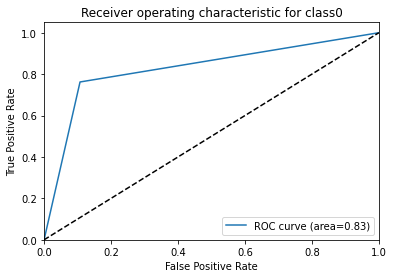

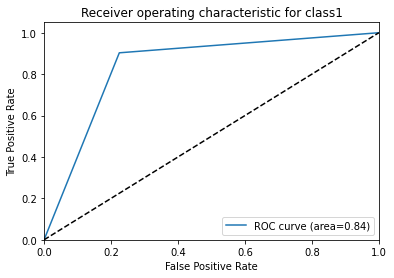

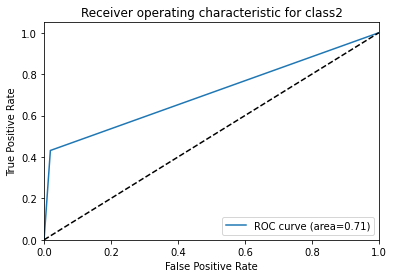

INFO:logger:matthews_correlation_coefficient =0.6466987929432327
INFO:logger:true positive =[1429 3825  245]
INFO:logger:true negative =[4288 1894 5996]
INFO:logger:false positive =[516 549 115]
INFO:logger:false negative =[446 411 323]
INFO:logger:precision =[0.76213333 0.9029745  0.43133803]
INFO:logger:recall =[0.76213333 0.9029745  0.43133803]
INFO:logger:F1 =[0.76213333 0.9029745  0.43133803]
INFO:logger:accuracy =[0.85596646 0.85626591 0.93442132]


In [ ]:
#ROC curve
f_pr=dict()
t_pr=dict()
ROC_AUC=dict()
test_data_y=label_binarize(test_data_y,classes=[0,1,2])
for i in range(num_classes):
    
    f_pr[i],t_pr[i], threshhold=roc_curve(test_data_y[:,i],predicted[:,i])
    ROC_AUC[i]=auc(f_pr[i],t_pr[i])
for i in range(num_classes):
    plt.figure()
    plt.plot(f_pr[i],t_pr[i],label='ROC curve (area=%0.2f)' % ROC_AUC[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class'+str(i))
    plt.legend(loc="lower right")
    plt.show()
    

plt.show()
for k in (results.keys()):
    logger.info('%s =%s',k,str(results[k]))
     

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(test_data_y, predicted,digits=6,target_names=['0','1','2']))
print(f'ACCURACY of the BI-LSTM Model:{accuracy_score(test_data_y,predicted)} ')

              precision    recall  f1-score   support

           0   0.734704  0.762133  0.748168      1875
           1   0.874486  0.902975  0.888502      4236
           2   0.680556  0.431338  0.528017       568

   micro avg   0.823327  0.823327  0.823327      6679
   macro avg   0.763249  0.698815  0.721562      6679
weighted avg   0.818752  0.823327  0.818449      6679
 samples avg   0.823327  0.823327  0.823327      6679

ACCURACY of the BI-LSTM Model:0.8233268453361282 
